<a href="https://colab.research.google.com/github/vestinabert/Image_Quality_Assessment/blob/main/Image_Edge_Detection_And_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 02025.jpg to 02025 (1).jpg


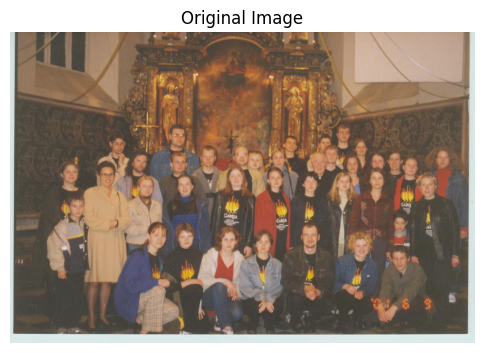

In [6]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# Upload images
uploaded = files.upload()

# Load and display the first uploaded image
image_name = list(uploaded.keys())[0]
image = cv2.imdecode(np.frombuffer(uploaded[image_name], np.uint8), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Show original image
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()


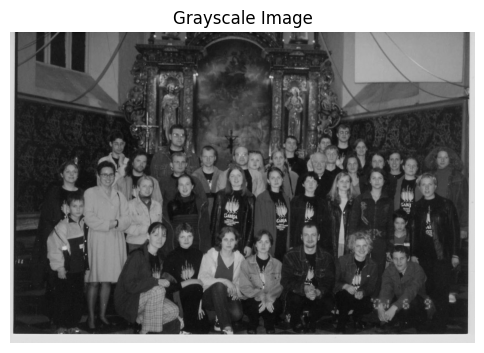

In [7]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Show grayscale image
plt.figure(figsize=(6,6))
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.show()


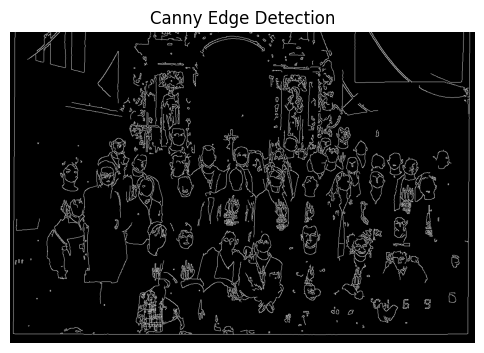

In [8]:
# Apply Canny Edge Detection
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Show edges
plt.figure(figsize=(6,6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()
